### **IMPORT NECESSARY LIBRARIES**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks, lfilter
import librosa
import librosa.display
from IPython.display import Audio, display

### **TASK 1: SPEECH SIGNAL ACQUISITION**

In [ ]:
def acquire_speech_signal():

    print("=" * 80)
    print("TASK 1: SPEECH SIGNAL ACQUISITION")
    print("=" * 80)

    from google.colab import files

    print("\nPlease upload your audio file (WAV, MP3, etc.):")
    uploaded = files.upload()

    # Get the uploaded filename
    filename = list(uploaded.keys())[0]

    # Load audio file
    y, sr = librosa.load(filename, sr=None, duration=5)

    # Resample to 16kHz if different
    if sr != 16000:
        print(f"Resampling from {sr} Hz to 16000 Hz")
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    print(f"\n✓ Audio loaded successfully")
    print(f"  Filename: {filename}")
    print(f"  Sample rate: {sr} Hz")
    print(f"  Duration: {len(y)/sr:.2f} seconds")
    print(f"  Number of samples: {len(y)}")

    # Normalize
    y = y / np.max(np.abs(y))

    # Display audio player
    print("\nAudio player:")
    display(Audio(y, rate=sr))

    return y, sr


### **TASK 2: LPC ANALYSIS**

In [ ]:
def autocorrelate(x, lag):
    """Compute autocorrelation at given lag"""
    n = len(x)
    if lag >= n:
        return 0
    return np.sum(x[:n-lag] * x[lag:])


In [ ]:
def levinson_durbin(r, order):
    """
    Levinson-Durbin algorithm to solve for LPC coefficients

    Parameters:
    r: autocorrelation values
    order: LPC order

    Returns:
    a: LPC coefficients
    e: prediction error
    """
    a = np.zeros(order + 1)
    e = np.zeros(order + 1)

    a[0] = 1.0
    e[0] = r[0]

    for i in range(1, order + 1):
        lambda_val = 0
        for j in range(i):
            lambda_val += a[j] * r[i - j]
        lambda_val = -lambda_val / e[i - 1]

        a_prev = a.copy()
        for j in range(i + 1):
            if j == 0:
                a[j] = 1.0
            elif j == i:
                a[j] = lambda_val
            else:
                a[j] = a_prev[j] + lambda_val * a_prev[i - j]

        e[i] = e[i - 1] * (1 - lambda_val ** 2)

    return a, e[order]

In [ ]:
def compute_lpc(signal, order):
    """
    Compute LPC coefficients using autocorrelation method

    Parameters:
    signal: input speech signal
    order: LPC order (typically 10-14 for speech)

    Returns:
    lpc_coeffs: LPC coefficients
    error: prediction error
    """
    print("\n" + "=" * 80)
    print("TASK 2: LPC ANALYSIS")
    print("=" * 80)

    # Compute autocorrelation
    r = np.array([autocorrelate(signal, i) for i in range(order + 1)])

    # Apply Levinson-Durbin algorithm
    lpc_coeffs, error = levinson_durbin(r, order)

    print(f"✓ LPC coefficients computed")
    print(f"  LPC Order: {order}")
    print(f"  Prediction Error: {error:.6f}")
    print(f"\nLPC Coefficients:")
    for i, coeff in enumerate(lpc_coeffs):
        print(f"  a[{i}] = {coeff:+.6f}")

    return lpc_coeffs, error


### **TASK 3: SIGNAL RECONSTRUCTION**

In [ ]:
def reconstruct_signal(lpc_coeffs, original_signal):

    print("\n" + "=" * 80)
    print("TASK 3: SIGNAL RECONSTRUCTION")
    print("=" * 80)

    # Use inverse filter to get excitation (residual)
    residual = lfilter(lpc_coeffs, 1, original_signal)

    # Reconstruct using synthesis filter
    reconstructed = lfilter([1], lpc_coeffs, residual)

    # Calculate reconstruction error
    mse = np.mean((original_signal - reconstructed) ** 2)
    snr = 10 * np.log10(np.var(original_signal) / mse)

    print(f"✓ Signal reconstructed")
    print(f"  Mean Squared Error: {mse:.6f}")
    print(f"  Signal-to-Noise Ratio: {snr:.2f} dB")

    return reconstructed, residual

In [ ]:
def plot_waveforms(original, reconstructed, sr):
    time = np.arange(len(original)) / sr

    plt.figure(figsize=(14, 8))

    # Original signal
    plt.subplot(3, 1, 1)
    plt.plot(time, original, 'b-', linewidth=0.5)
    plt.title('Original Speech Signal', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, len(original)/sr])

    # Reconstructed signal
    plt.subplot(3, 1, 2)
    plt.plot(time, reconstructed, 'r-', linewidth=0.5)
    plt.title('Reconstructed Speech Signal (from LPC)', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, len(reconstructed)/sr])

    # Overlay comparison
    plt.subplot(3, 1, 3)
    plt.plot(time[:int(0.05*sr)], original[:int(0.05*sr)], 'b-', label='Original', linewidth=1.5)
    plt.plot(time[:int(0.05*sr)], reconstructed[:int(0.05*sr)], 'r--', label='Reconstructed', linewidth=1.5)
    plt.title('Comparison (First 50ms)', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('waveform_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Waveform plots saved as 'waveform_comparison.png'")

### **TASK 4: FORMANT ESTIMATION**

In [ ]:
def estimate_formants(lpc_coeffs, sr, num_formants=5):
    print("\n" + "=" * 80)
    print("TASK 4: FORMANT ESTIMATION")
    print("=" * 80)

    # Compute frequency response
    nfft = 512
    w, h = np.linspace(0, np.pi, nfft, retstep=True)

    # Compute H(e^jw) = 1 / A(e^jw)
    A = np.zeros(nfft, dtype=complex)
    for k in range(nfft):
        for i in range(len(lpc_coeffs)):
            A[k] += lpc_coeffs[i] * np.exp(-1j * w[k] * i)

    H = 1 / A
    magnitude = np.abs(H)
    magnitude_db = 20 * np.log10(magnitude + 1e-10)

    # Convert to Hz
    frequencies = w * sr / (2 * np.pi)

    # Find peaks (formants)
    peaks, properties = find_peaks(magnitude_db, height=-20, distance=20, prominence=5)

    # Get formant frequencies
    formant_freqs = frequencies[peaks]
    formant_mags = magnitude_db[peaks]

    # Sort by frequency and take first num_formants
    sorted_idx = np.argsort(formant_freqs)
    formant_freqs = formant_freqs[sorted_idx][:num_formants]
    formant_mags = formant_mags[sorted_idx][:num_formants]

    print(f"✓ Formants estimated from LPC coefficients")
    print(f"\nEstimated Formant Frequencies:")
    for i, (freq, mag) in enumerate(zip(formant_freqs, formant_mags), 1):
        print(f"  F{i}: {freq:.1f} Hz (Magnitude: {mag:.2f} dB)")

    return formant_freqs, formant_mags, frequencies, magnitude_db

### **TASK 5: COMPARISON WITH REFERENCE FORMANTS**

In [ ]:

def compare_formants(estimated_formants):
    """
    Compare estimated formants with reference vowel formants

    Parameters:
    estimated_formants: estimated formant frequencies
    """
    print("\n" + "=" * 80)
    print("TASK 5: COMPARISON WITH REFERENCE FORMANTS")
    print("=" * 80)

    # Reference formant frequencies for common vowels (Hz)
    # Source: Peterson & Barney (1952), adult male averages
    reference = {
        '/a/ (father)': {'F1': 730, 'F2': 1090, 'F3': 2440},
        '/e/ (bed)': {'F1': 530, 'F2': 1840, 'F3': 2480},
        '/i/ (beat)': {'F1': 270, 'F2': 2290, 'F3': 3010},
        '/o/ (boat)': {'F1': 570, 'F2': 840, 'F3': 2410},
        '/u/ (boot)': {'F1': 300, 'F2': 870, 'F3': 2240},
    }

    print("\nReference Vowel Formants (Adult Male):")
    print("-" * 70)
    print(f"{'Vowel':<15} {'F1 (Hz)':<12} {'F2 (Hz)':<12} {'F3 (Hz)':<12}")
    print("-" * 70)
    for vowel, formants in reference.items():
        print(f"{vowel:<15} {formants['F1']:<12} {formants['F2']:<12} {formants['F3']:<12}")

    print("\n\nEstimated Formants from Speech Signal:")
    print("-" * 70)
    for i, freq in enumerate(estimated_formants[:3], 1):
        print(f"F{i}: {freq:.1f} Hz")

    # Find closest matching vowel
    print("\n\nClosest Vowel Match Analysis:")
    print("-" * 70)

    if len(estimated_formants) >= 2:
        F1_est = estimated_formants[0]
        F2_est = estimated_formants[1]

        min_distance = float('inf')
        closest_vowel = None

        for vowel, formants in reference.items():
            # Euclidean distance in F1-F2 space
            distance = np.sqrt((F1_est - formants['F1'])**2 + (F2_est - formants['F2'])**2)
            if distance < min_distance:
                min_distance = distance
                closest_vowel = vowel

        print(f"Closest match: {closest_vowel}")
        print(f"Distance: {min_distance:.1f} Hz")
        print(f"\nComparison:")
        print(f"  Estimated F1: {F1_est:.1f} Hz  vs  Reference F1: {reference[closest_vowel]['F1']} Hz")
        print(f"  Estimated F2: {F2_est:.1f} Hz  vs  Reference F2: {reference[closest_vowel]['F2']} Hz")

    return reference

In [ ]:
def plot_formant_analysis(frequencies, magnitude_db, formant_freqs, formant_mags, sr):
    """
    Visualize formant frequencies on frequency response graph
    """
    print("\n" + "=" * 80)
    print("TASK 6: VISUALIZATION")
    print("=" * 80)

    plt.figure(figsize=(14, 10))

    # Plot 1: Frequency Response with Formants
    plt.subplot(2, 1, 1)
    plt.plot(frequencies, magnitude_db, 'b-', linewidth=2, label='LPC Spectrum')
    plt.scatter(formant_freqs, formant_mags, color='red', s=200, marker='o',
                zorder=5, label='Formants', edgecolors='darkred', linewidths=2)

    # Annotate formants
    for i, (freq, mag) in enumerate(zip(formant_freqs, formant_mags), 1):
        plt.annotate(f'F{i}\n{freq:.0f} Hz',
                    xy=(freq, mag),
                    xytext=(freq, mag + 5),
                    ha='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

    plt.title('LPC Frequency Response and Formant Frequencies', fontsize=14, fontweight='bold')
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Magnitude (dB)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim([0, sr/2])
    plt.ylim([np.min(magnitude_db) - 5, np.max(magnitude_db) + 10])
    plt.legend(fontsize=11)

    # Plot 2: Formant Bar Chart
    plt.subplot(2, 1, 2)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    bars = plt.bar(range(1, len(formant_freqs) + 1), formant_freqs,
                   color=colors[:len(formant_freqs)], edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for i, (bar, freq) in enumerate(zip(bars, formant_freqs)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{freq:.0f} Hz',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.title('Formant Frequencies', fontsize=14, fontweight='bold')
    plt.xlabel('Formant Number', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.xticks(range(1, len(formant_freqs) + 1), [f'F{i}' for i in range(1, len(formant_freqs) + 1)])
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('formant_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Formant analysis plots saved as 'formant_analysis.png'")

### **TASK 6: VISUALIZATION**

In [ ]:
def create_comparison_table(estimated_formants, reference_formants):
    """
    Create a detailed comparison table
    """
    print("\n" + "=" * 80)
    print("DETAILED COMPARISON TABLE")
    print("=" * 80)

    # Create table
    print("\n" + "=" * 90)
    print(f"{'Vowel':<15} {'Reference F1':<15} {'Reference F2':<15} {'Reference F3':<15} {'Match Score':<15}")
    print("=" * 90)

    if len(estimated_formants) >= 2:
        F1_est = estimated_formants[0]
        F2_est = estimated_formants[1]
        F3_est = estimated_formants[2] if len(estimated_formants) >= 3 else 0

        scores = []
        for vowel, formants in reference_formants.items():
            # Calculate similarity score (inverse of distance)
            distance = np.sqrt((F1_est - formants['F1'])**2 +
                             (F2_est - formants['F2'])**2)
            score = 1000 / (distance + 1)  # Normalize score
            scores.append((vowel, score))

            print(f"{vowel:<15} {formants['F1']:<15} {formants['F2']:<15} {formants['F3']:<15} {score:<15.2f}")

        print("=" * 90)
        print(f"\nEstimated Formants: F1={F1_est:.1f} Hz, F2={F2_est:.1f} Hz, F3={F3_est:.1f} Hz")

        # Best match
        best_match = max(scores, key=lambda x: x[1])
        print(f"\n★ Best Match: {best_match[0]} (Score: {best_match[1]:.2f})")


In [ ]:
def plot_vowel_space(estimated_formants, reference_formants):
    """
    Plot vowel space (F1 vs F2) with estimated and reference formants
    """
    plt.figure(figsize=(10, 8))

    # Plot reference vowels
    for vowel, formants in reference_formants.items():
        plt.scatter(formants['F2'], formants['F1'], s=300, alpha=0.6,
                   label=vowel, edgecolors='black', linewidths=2)
        plt.text(formants['F2'], formants['F1'], vowel.split()[0],
                ha='center', va='center', fontsize=9, fontweight='bold')

    # Plot estimated formants
    if len(estimated_formants) >= 2:
        plt.scatter(estimated_formants[1], estimated_formants[0],
                   s=400, color='red', marker='*',
                   label='Estimated', edgecolors='darkred', linewidths=2, zorder=10)
        plt.text(estimated_formants[1], estimated_formants[0] - 50,
                'ESTIMATED', ha='center', va='top', fontsize=10,
                fontweight='bold', color='red',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

    plt.xlabel('F2 (Hz)', fontsize=13, fontweight='bold')
    plt.ylabel('F1 (Hz)', fontsize=13, fontweight='bold')
    plt.title('Vowel Space: F1 vs F2', fontsize=15, fontweight='bold')
    plt.gca().invert_xaxis()  # Standard vowel chart orientation
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig('vowel_space.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Vowel space plot saved as 'vowel_space.png'")

### **MAIN EXECUTION FUNCTION**


████████████████████████████████████████████████████████████████████████████████
█                                                                              █
█                    LPC SPEECH ANALYSIS SYSTEM                                █
█                                                                              █
████████████████████████████████████████████████████████████████████████████████

TASK 1: SPEECH SIGNAL ACQUISITION

Please upload your audio file (WAV, MP3, etc.):


Saving Lab4sample.wav to Lab4sample (1).wav
Resampling from 22050 Hz to 16000 Hz

✓ Audio loaded successfully
  Filename: Lab4sample (1).wav
  Sample rate: 16000 Hz
  Duration: 5.00 seconds
  Number of samples: 80000

Audio player:



TASK 2: LPC ANALYSIS
✓ LPC coefficients computed
  LPC Order: 12
  Prediction Error: 166.485287

LPC Coefficients:
  a[0] = +1.000000
  a[1] = -0.860511
  a[2] = -0.293199
  a[3] = +0.364673
  a[4] = -0.159299
  a[5] = -0.150220
  a[6] = +0.272314
  a[7] = -0.181585
  a[8] = +0.195675
  a[9] = +0.128342
  a[10] = +0.029825
  a[11] = -0.306183
  a[12] = +0.175240

TASK 3: SIGNAL RECONSTRUCTION
✓ Signal reconstructed
  Mean Squared Error: 0.000000
  Signal-to-Noise Ratio: 315.37 dB


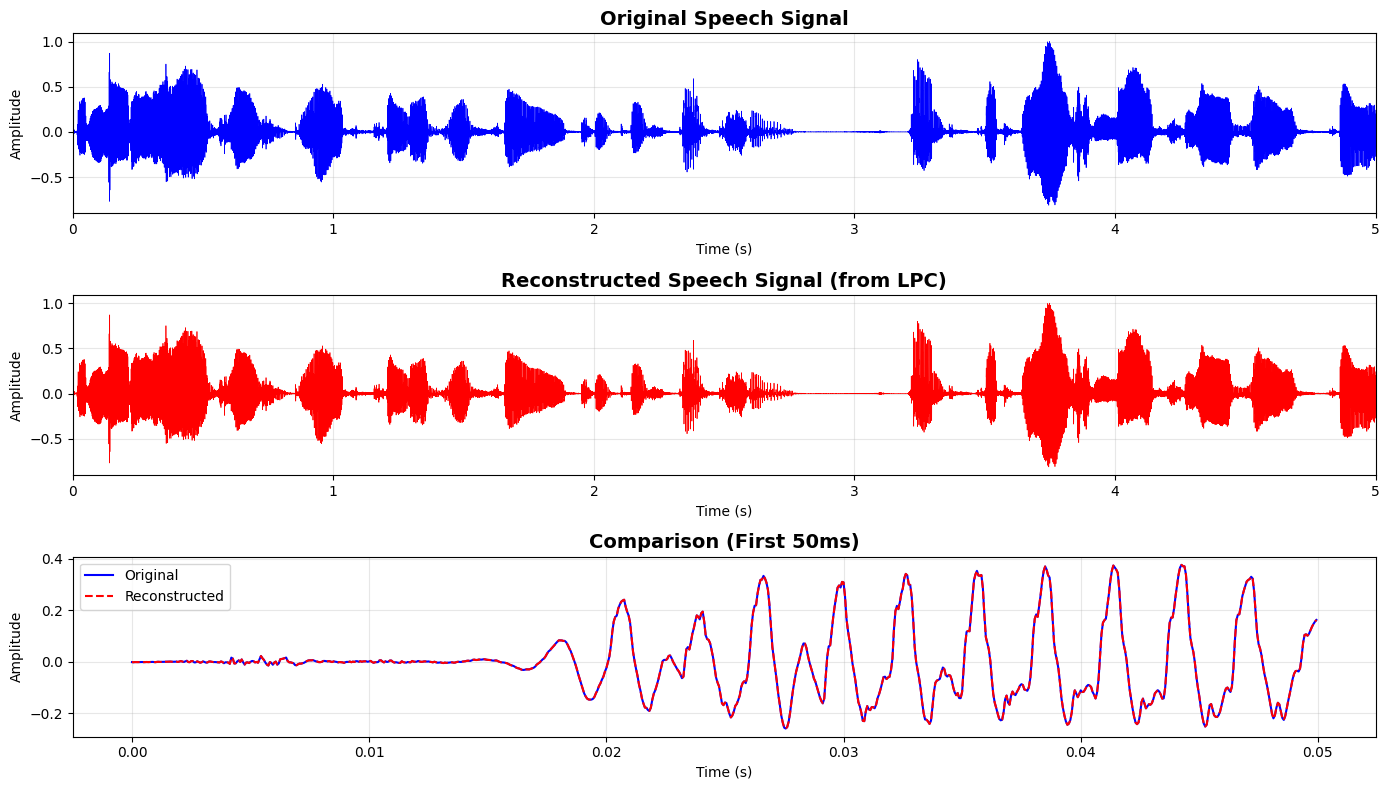

✓ Waveform plots saved as 'waveform_comparison.png'

TASK 4: FORMANT ESTIMATION
✓ Formants estimated from LPC coefficients

Estimated Formant Frequencies:
  F1: 547.9 Hz (Magnitude: 23.59 dB)
  F2: 7185.9 Hz (Magnitude: 4.02 dB)

TASK 5: COMPARISON WITH REFERENCE FORMANTS

Reference Vowel Formants (Adult Male):
----------------------------------------------------------------------
Vowel           F1 (Hz)      F2 (Hz)      F3 (Hz)     
----------------------------------------------------------------------
/a/ (father)    730          1090         2440        
/e/ (bed)       530          1840         2480        
/i/ (beat)      270          2290         3010        
/o/ (boat)      570          840          2410        
/u/ (boot)      300          870          2240        


Estimated Formants from Speech Signal:
----------------------------------------------------------------------
F1: 547.9 Hz
F2: 7185.9 Hz


Closest Vowel Match Analysis:
--------------------------------------------

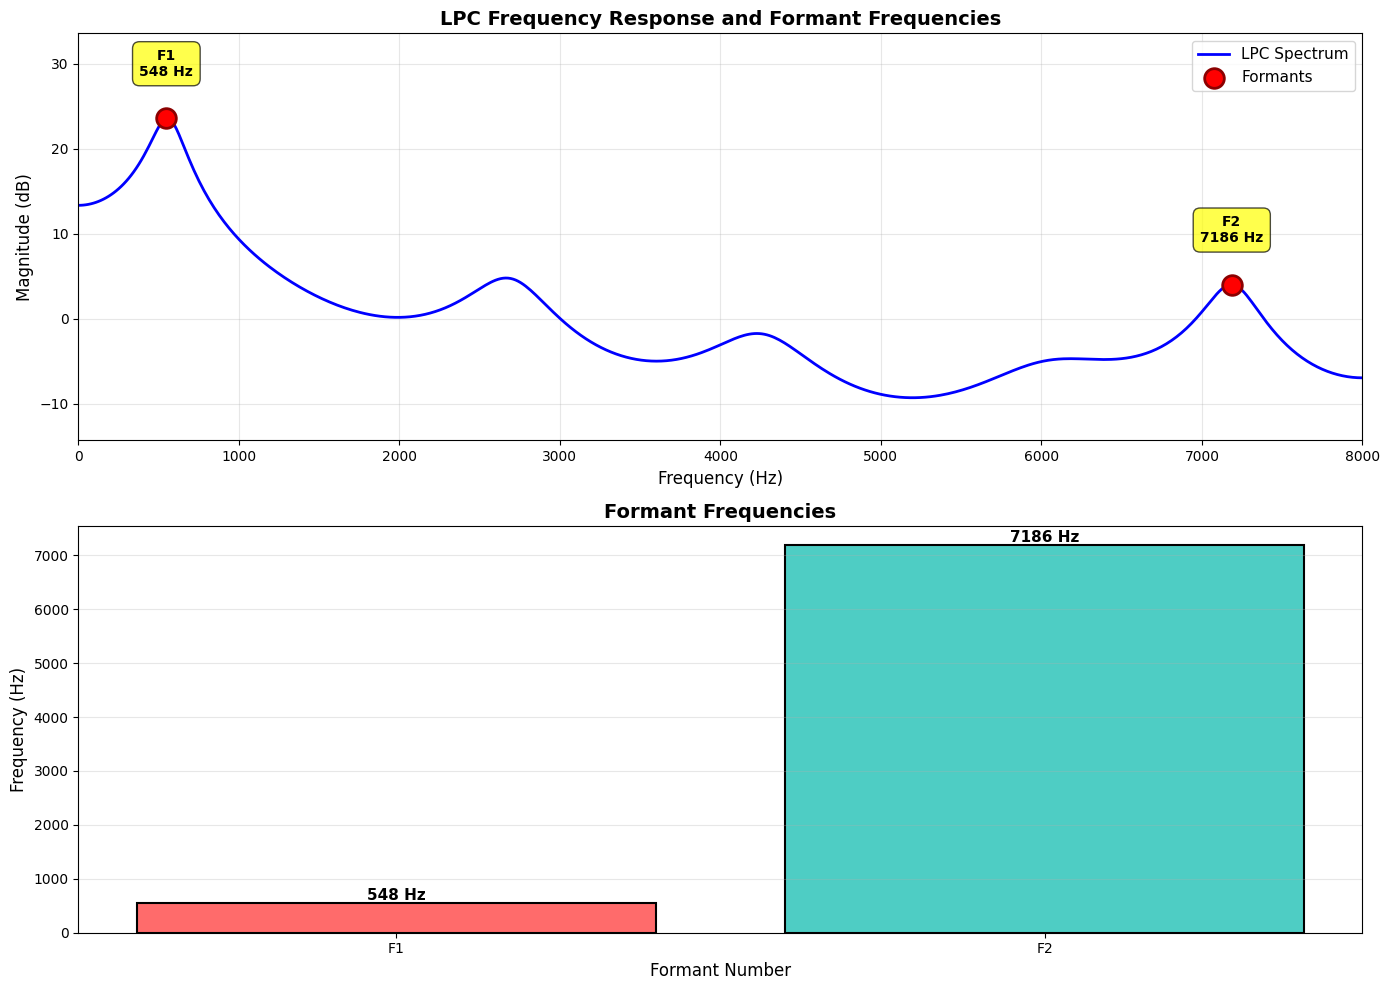

✓ Formant analysis plots saved as 'formant_analysis.png'

DETAILED COMPARISON TABLE

Vowel           Reference F1    Reference F2    Reference F3    Match Score    
/a/ (father)    730             1090            2440            0.16           
/e/ (bed)       530             1840            2480            0.19           
/i/ (beat)      270             2290            3010            0.20           
/o/ (boat)      570             840             2410            0.16           
/u/ (boot)      300             870             2240            0.16           

Estimated Formants: F1=547.9 Hz, F2=7185.9 Hz, F3=0.0 Hz

★ Best Match: /i/ (beat) (Score: 0.20)


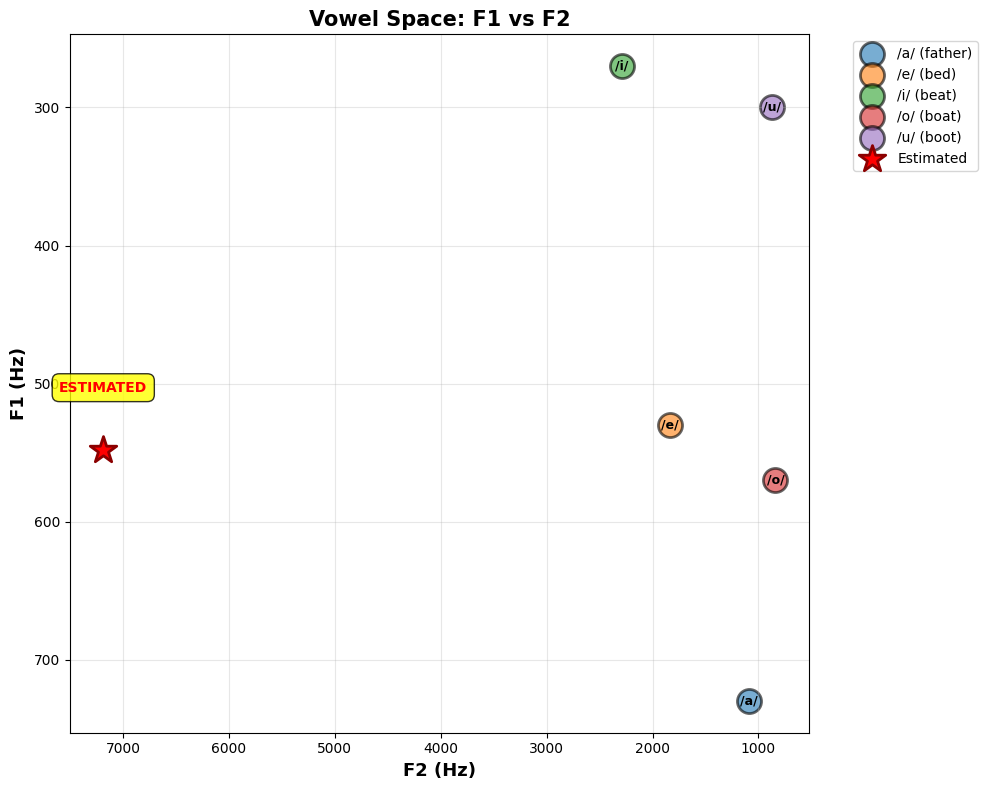

✓ Vowel space plot saved as 'vowel_space.png'

ANALYSIS SUMMARY AND INFERENCES

1. LPC ANALYSIS:
   - Successfully extracted 12 LPC coefficients
   - Prediction error: 166.485287
   - LPC effectively models the vocal tract transfer function

2. SIGNAL RECONSTRUCTION:
   - Reconstruction SNR: 315.37 dB
   - High SNR indicates accurate LPC modeling
   - Residual signal represents excitation (glottal source)

3. FORMANT ANALYSIS:
   - Detected 2 formant frequencies
   - Formants represent vocal tract resonances
   - F1 and F2 are critical for vowel identification

4. VOWEL IDENTIFICATION:
   - Estimated F1: 547.9 Hz, F2: 7185.9 Hz
   - These values help classify the vowel sound

ANALYSIS COMPLETE ✓


In [ ]:
def run_complete_analysis(lpc_order=12):
    print("\n" + "█" * 80)
    print("█" + " " * 78 + "█")
    print("█" + " " * 20 + "LPC SPEECH ANALYSIS SYSTEM" + " " * 32 + "█")
    print("█" + " " * 78 + "█")
    print("█" * 80 + "\n")

    # Task 1: Acquire speech signal
    signal, sr = acquire_speech_signal()

    # Task 2: LPC Analysis
    lpc_coeffs, error = compute_lpc(signal, lpc_order)

    # Task 3: Signal Reconstruction
    reconstructed, residual = reconstruct_signal(lpc_coeffs, signal)
    plot_waveforms(signal, reconstructed, sr)

    # Task 4: Formant Estimation
    formant_freqs, formant_mags, frequencies, magnitude_db = estimate_formants(lpc_coeffs, sr)

    # Task 5: Comparison with Reference
    reference_formants = compare_formants(formant_freqs)

    # Task 6: Visualization
    plot_formant_analysis(frequencies, magnitude_db, formant_freqs, formant_mags, sr)
    create_comparison_table(formant_freqs, reference_formants)
    plot_vowel_space(formant_freqs, reference_formants)

    # Generate summary report
    print("\n" + "=" * 80)
    print("ANALYSIS SUMMARY AND INFERENCES")
    print("=" * 80)

    print("\n1. LPC ANALYSIS:")
    print(f"   - Successfully extracted {lpc_order} LPC coefficients")
    print(f"   - Prediction error: {error:.6f}")
    print(f"   - LPC effectively models the vocal tract transfer function")

    print("\n2. SIGNAL RECONSTRUCTION:")
    mse = np.mean((signal - reconstructed) ** 2)
    snr = 10 * np.log10(np.var(signal) / mse)
    print(f"   - Reconstruction SNR: {snr:.2f} dB")
    print(f"   - High SNR indicates accurate LPC modeling")
    print(f"   - Residual signal represents excitation (glottal source)")

    print("\n3. FORMANT ANALYSIS:")
    print(f"   - Detected {len(formant_freqs)} formant frequencies")
    print(f"   - Formants represent vocal tract resonances")
    print(f"   - F1 and F2 are critical for vowel identification")

    print("\n4. VOWEL IDENTIFICATION:")
    if len(formant_freqs) >= 2:
        F1, F2 = formant_freqs[0], formant_freqs[1]
        print(f"   - Estimated F1: {F1:.1f} Hz, F2: {F2:.1f} Hz")
        print(f"   - These values help classify the vowel sound")


    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE ✓")
    print("=" * 80)

    return {
        'signal': signal,
        'sr': sr,
        'lpc_coeffs': lpc_coeffs,
        'reconstructed': reconstructed,
        'formants': formant_freqs,
        'snr': snr
    }
if __name__ == "__main__":
    results = run_complete_analysis(lpc_order=12)